In [1]:
import pandas as pd
import numpy as np
import os
import sys
import seaborn as sns

from matplotlib import pyplot as plt

In [2]:
root = os.getenv("HOME")
sys.path.append(f"{root}/personal_works/walmat-recruit-forecast")

In [3]:
stores_df = pd.read_csv("../data/raw_data/stores.csv")
train_df = pd.read_csv("../data/raw_data/train.csv")
features_df = pd.read_csv("../data/raw_data/features.csv")

# Fixing Data

In [4]:
# Finding there is negative in weekly sales amount which is impossible
train_df["Weekly_Sales"] = train_df["Weekly_Sales"].apply(lambda x: 0 if x < 0 else x)
train_df = pd.merge(
    left=train_df,
    right=stores_df[["Store", "Type"]],
    left_on=["Store"],
    right_on=["Store"],
    how="left",
)
train_df["Date"] = pd.to_datetime(train_df["Date"])

train_df.to_csv("../data/processed_data/train.csv", index=False)

# Crate table contains sales per store
train_store_df = (
    train_df.groupby(["Date", "Store", "IsHoliday", "Type"])
    .agg(sales=("Weekly_Sales", "sum"))
    .reset_index()
)

train_store_df.to_csv("../data/processed_data/train_store.csv", index=False)

# Create table contains train dataset with features
features_df["Date"] = pd.to_datetime(features_df["Date"])

train_features_df = pd.merge(
    left=train_df, right=features_df, on=["Store", "Date"], how="left"
)
train_features_df.to_csv("../data/processed_data/train_features_df.csv", index=False)


# Crate table contains sales per store with features
train_store_features_df = pd.merge(
    left=train_store_df, right=features_df, on=["Store", "Date"], how="left"
)

train_store_features_df.to_csv("../data/processed_data/train_store_features.csv", index=False)

# Processing Data

In [5]:
sales_per_day = (
    train_df.groupby(["Date", "Store"]).agg(sales=("Weekly_Sales", "sum")).reset_index()
)

features_df["Date"] = pd.to_datetime(features_df["Date"])
features_train_df = pd.merge(
    left=features_df,
    right=sales_per_day,
    left_on=["Date", "Store"],
    right_on=["Date", "Store"],
    how="inner",
)

features_train_df.to_csv("../data/processed_data/features_train_df.csv", index=False)

# Stores Analysis

Synopsis
- Store Type seems to have significant impact to sales
- Features seem to have more impact as ploting graph in stores analysis show that the sales trend quite align regardless of the dimension

In [6]:
print(f"number of stores: {len(stores_df.Store.unique())}")

number of stores: 45


In [7]:
sale_stores_dep_df = (
    train_df.groupby(["Store", "Dept"])
    .agg(sales=("Weekly_Sales", "sum"), num_date=("Date", "count"))
    .reset_index()
)
stores_dept_df = pd.merge(
    left=stores_df,
    right=sale_stores_dep_df,
    left_on=["Store"],
    right_on=["Store"],
    how="left",
)

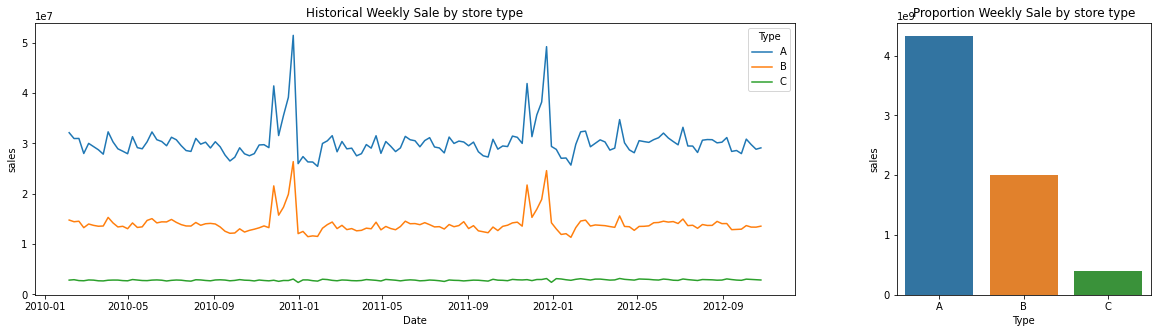

In [8]:
sales_by_type = (
    stores_dept_df.groupby(["Type"]).agg(sales=("sales", "sum")).reset_index()
)

sales_by_type_date = (
    train_df.groupby(["Type", "Date"]).agg(sales=("Weekly_Sales", "sum")).reset_index()
)


plt.subplots(1, 2, gridspec_kw={"width_ratios": [3, 1]}, figsize=(20, 5))

plt.subplot(1, 2, 1)
g1 = sns.lineplot(data=sales_by_type_date, x="Date", y="sales", hue="Type")
plt.title("Historical Weekly Sale by store type")

plt.subplot(1, 2, 2)
g2 = sns.barplot(data=sales_by_type, x="Type", y="sales")
plt.title("Proportion Weekly Sale by store type")

plt.show()

In [9]:
sales_by_dep = (
    stores_dept_df.groupby(["Dept"]).agg(sales=("sales", "sum")).reset_index()
)
sales_by_dep["sales_portion"] = sales_by_dep["sales"] / sales_by_dep["sales"].sum()
sales_by_dep.sort_values(by="sales_portion", ascending=False, inplace=True)
sales_by_dep["cum_sales_portion"] = sales_by_dep[
    "sales_portion"
].cumsum()  # 40 dep from all 81 dep contribute 90 of sales already

sales_by_dep_date = (
    train_df.groupby(["Dept", "Date"]).agg(sales=("Weekly_Sales", "sum")).reset_index()
)

dep_per_store = (
    stores_dept_df.groupby(["Store"]).agg(num_dep=("Dept", "count")).reset_index()
)

Text(0.5, 1.0, 'Number of department per store')

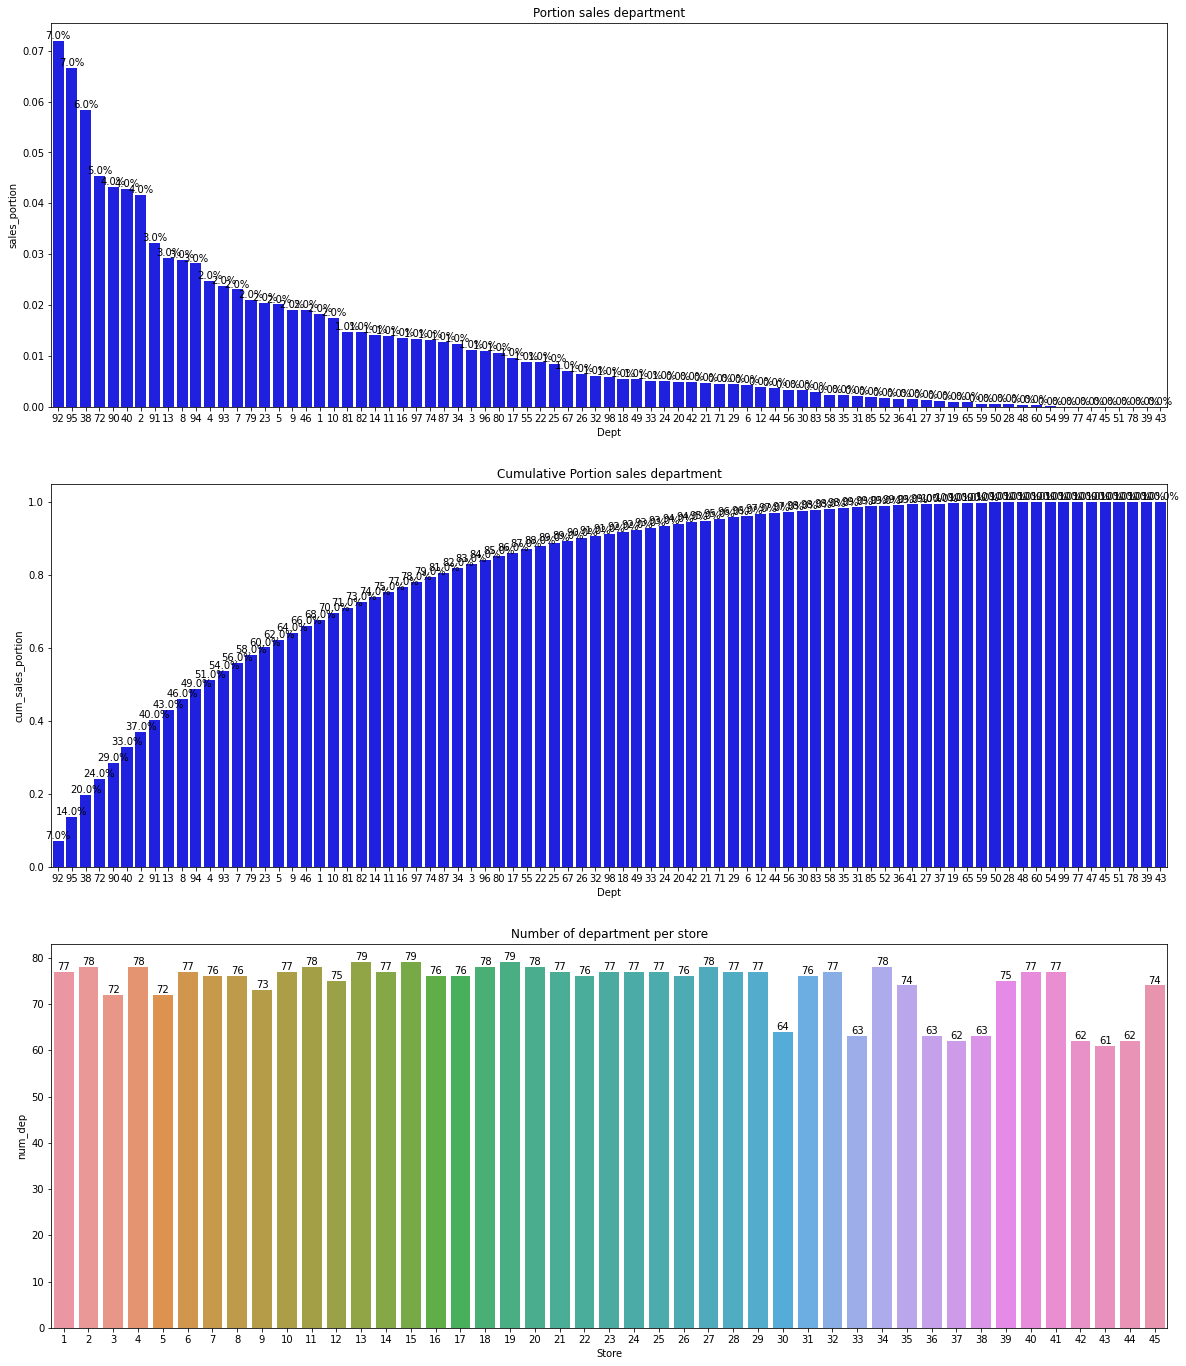

In [10]:
plt.subplots(3, 1, figsize=(20, 8 * 3))

plt.subplot(3, 1, 1)
g1 = sns.barplot(
    data=sales_by_dep,
    x="Dept",
    y="sales_portion",
    order=sales_by_dep.sort_values(by="sales_portion", ascending=False).Dept,
    color="b",
)
g1_label = [f"{round(100*a,0)}%" for a in sales_by_dep.sales_portion]
g1.bar_label(g1.containers[0], labels=g1_label)
plt.title("Portion sales department")

plt.subplot(3, 1, 2)
g2 = sns.barplot(
    data=sales_by_dep,
    x="Dept",
    y="cum_sales_portion",
    order=sales_by_dep.sort_values(by="sales_portion", ascending=False).Dept,
    color="b",
)
g2_label = [f"{round(100*a,0)}%" for a in sales_by_dep.cum_sales_portion]
g2.bar_label(g2.containers[0], labels=g2_label)
plt.title("Cumulative Portion sales department")

plt.subplot(3, 1, 3)
g3 = sns.barplot(data=dep_per_store, x="Store", y="num_dep")
g3_label = [f"{a}" for a in dep_per_store.num_dep]
g3.bar_label(g3.containers[0], labels=g3_label)
plt.title("Number of department per store")

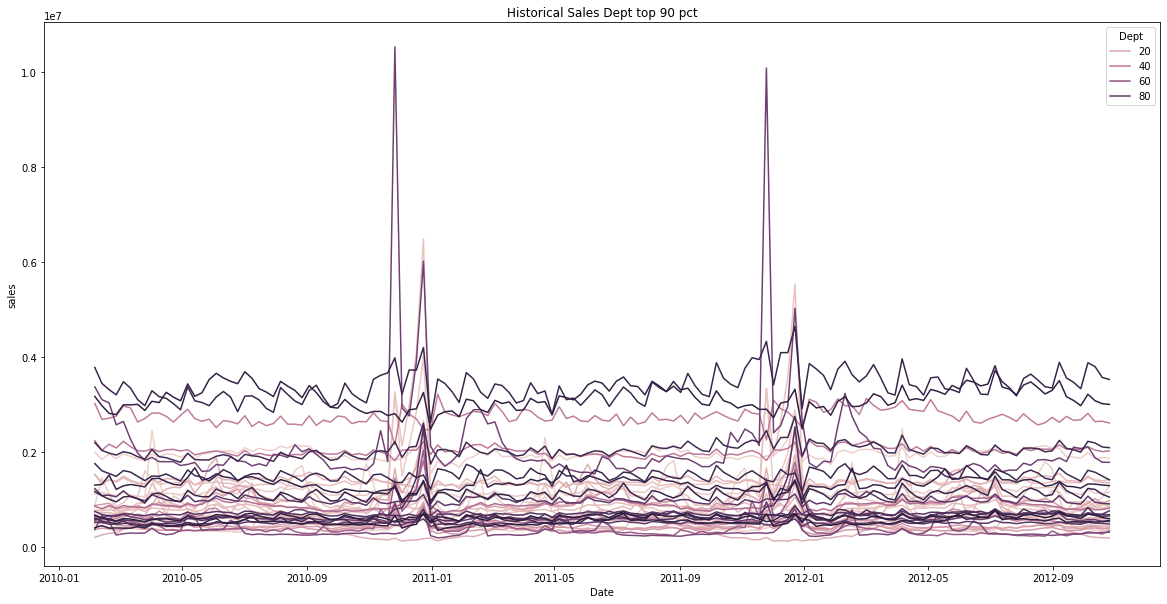

In [11]:
sales_by_dep_90pct = sales_by_dep[sales_by_dep.cum_sales_portion <= 0.9].copy()
sales_by_dep_90pct = sales_by_dep_90pct.reset_index(drop=True)

ls_dep_sales_90 = list(sales_by_dep_90pct.Dept)

sales_by_dep_date_90pct = sales_by_dep_date[
    sales_by_dep_date.Dept.isin(ls_dep_sales_90)
]

plt.figure(figsize=(20, 10))
g1 = sns.lineplot(data=sales_by_dep_date_90pct, x="Date", y="sales", hue="Dept")
plt.title("Historical Sales Dept top 90 pct")
plt.show()

In [12]:
sales_by_store = (
    train_df.groupby(["Store", "Type"]).agg(sales=("Weekly_Sales", "sum")).reset_index()
)
sales_by_store["sales_portion"] = sales_by_store["sales"] / sales_by_store.sales.sum()
sales_by_store.sort_values(by="sales_portion", ascending=False, inplace=True)
sales_by_store["cum_sales_portion"] = sales_by_store["sales_portion"].cumsum()
sales_by_store = sales_by_store.reset_index(drop=True)


sales_by_store_date = (
    train_df.groupby(["Store", "Date"]).agg(sales=("Weekly_Sales", "sum")).reset_index()
)

Text(0.5, 1.0, 'Cumulative Portion by store')

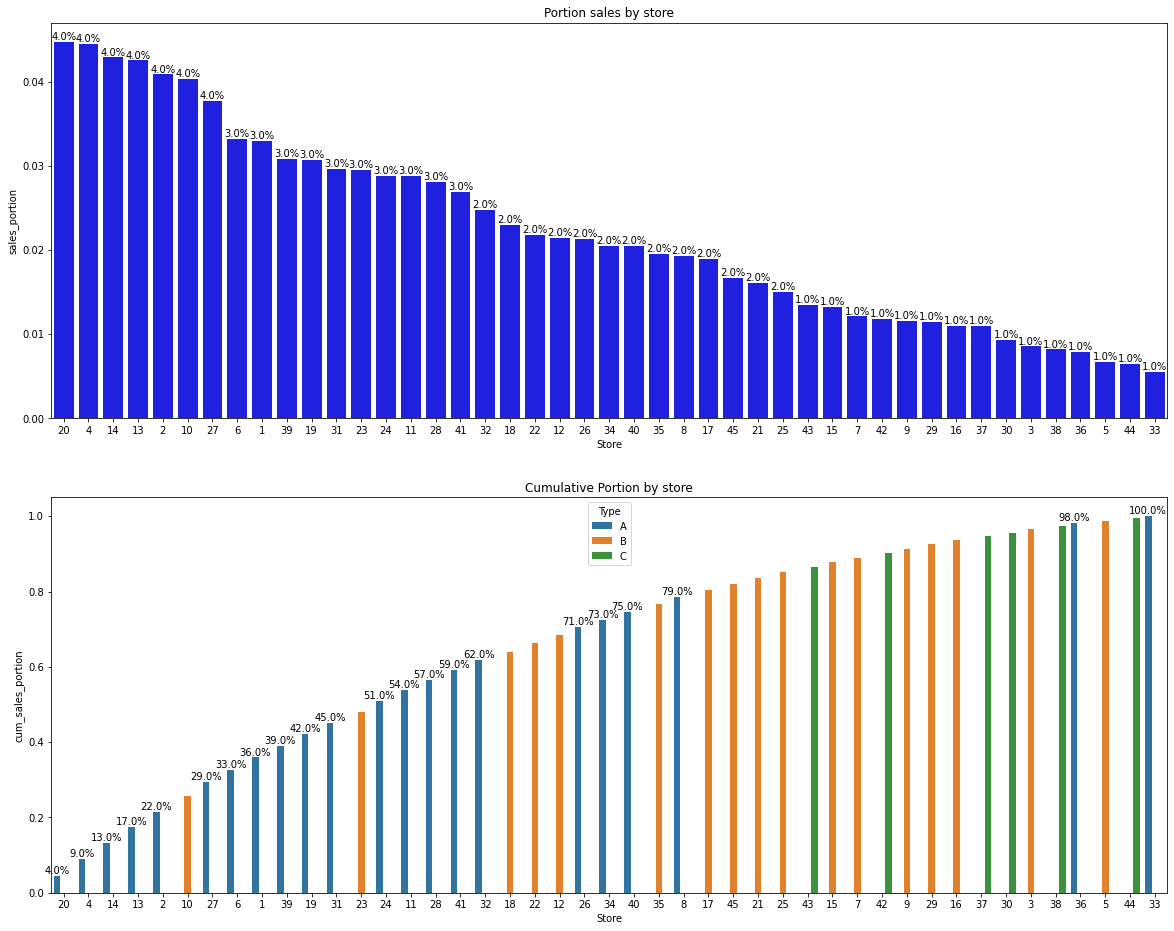

In [13]:
plt.subplots(2, 1, figsize=(20, 8 * 2))

plt.subplot(2, 1, 1)
g1 = sns.barplot(
    data=sales_by_store,
    x="Store",
    y="sales_portion",
    order=sales_by_store.sort_values(by="sales_portion", ascending=False).Store,
    color="b",
)
g1_label = [f"{round(100*a,0)}%" for a in sales_by_store.sales_portion]
g1.bar_label(g1.containers[0], labels=g1_label)
plt.title("Portion sales by store")

plt.subplot(2, 1, 2)
g2 = sns.barplot(
    data=sales_by_store,
    x="Store",
    y="cum_sales_portion",
    order=sales_by_store.sort_values(by="sales_portion", ascending=False).Store,
    hue="Type",
)
g2_label = [f"{round(100*a,0)}%" for a in sales_by_store.cum_sales_portion]
g2.bar_label(g2.containers[0], labels=g2_label)
plt.title("Cumulative Portion by store")

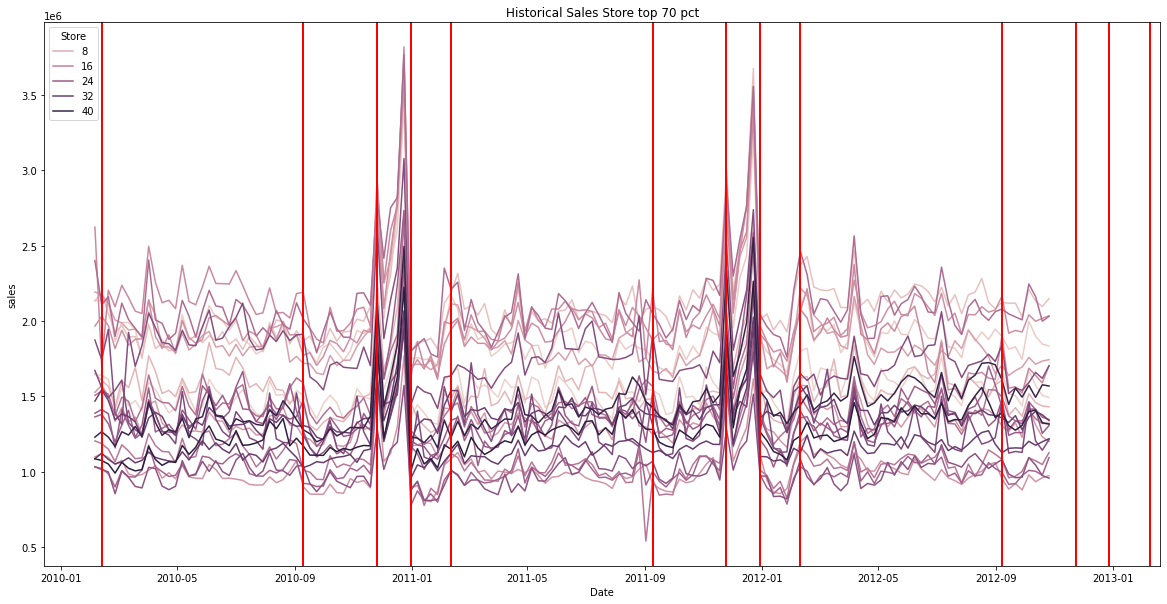

In [14]:
sales_by_store_top70pct = sales_by_store[sales_by_store.cum_sales_portion < 0.71].copy()
ls_store_sales_top70pct = list(sales_by_store_top70pct.Store)

sales_by_store_date_top70pct = sales_by_store_date[
    sales_by_store_date.Store.isin(ls_store_sales_top70pct)
]

ls_holiday = list(features_df[features_df.IsHoliday].Date.values)

plt.figure(figsize=(20, 10))
g1 = sns.lineplot(data=sales_by_store_date_top70pct, x="Date", y="sales", hue="Store")

for date in ls_holiday:
    plt.axvline(x=date, color="r", label="axvline - full height")

plt.title("Historical Sales Store top 70 pct")
plt.show()

# Analysis features

In [15]:
features_train_df = pd.read_csv("../data/processed_data/features_train_df.csv")
print(features_train_df.isnull().sum())

Store              0
Date               0
Temperature        0
Fuel_Price         0
MarkDown1       4155
MarkDown2       4798
MarkDown3       4389
MarkDown4       4470
MarkDown5       4140
CPI                0
Unemployment       0
IsHoliday          0
sales              0
dtype: int64


In [16]:
# check_isholiday = features_train_df.groupby(["Date", "IsHoliday"]).Store.count().reset_index()
# check_isholiday = check_isholiday.groupby(["Date"]).IsHoliday.count().reset_index()
# print(check_isholiday[check_isholiday.IsHoliday > 1])

In [17]:
features_train_df = pd.read_csv("../data/processed_data/features_train_df.csv")
features_train_df["Date"] = pd.to_datetime(features_train_df["Date"])

sales_per_date = (
    features_train_df.groupby(["Date"])
    .agg(tt_sales_date=("sales", "sum"))
    .reset_index()
)

features_train_df = pd.merge(
    left=features_train_df,
    right=sales_per_date,
    left_on=["Date"],
    right_on=["Date"],
    how="left",
)

features_train_df["wavg_sales_date"] = (
    features_train_df["sales"] / features_train_df["tt_sales_date"]
)


"""
transfrom wavg features for analysis
"""
ls_trasforme_feats = list(features_train_df.columns)

for col in ["Date", "IsHoliday", "sales", "tt_sales_date", "wavg_sales_date", "Store"]:
    ls_trasforme_feats.remove(col)

for col in ls_trasforme_feats:
    new_col = "wavg_" + col
    features_train_df[new_col] = (
        features_train_df[col] * features_train_df["wavg_sales_date"]
    )

features_train_wavg_df = (
    features_train_df.groupby(["Date", "IsHoliday", "tt_sales_date"])
    .agg(
        wavg_temp=("wavg_Temperature", "sum"),
        wavg_fuel=("wavg_Fuel_Price", "sum"),
        wavg_cpi=("wavg_CPI", "sum"),
        wavg_unemploy=("wavg_Unemployment", "sum"),
    )
    .reset_index()
)

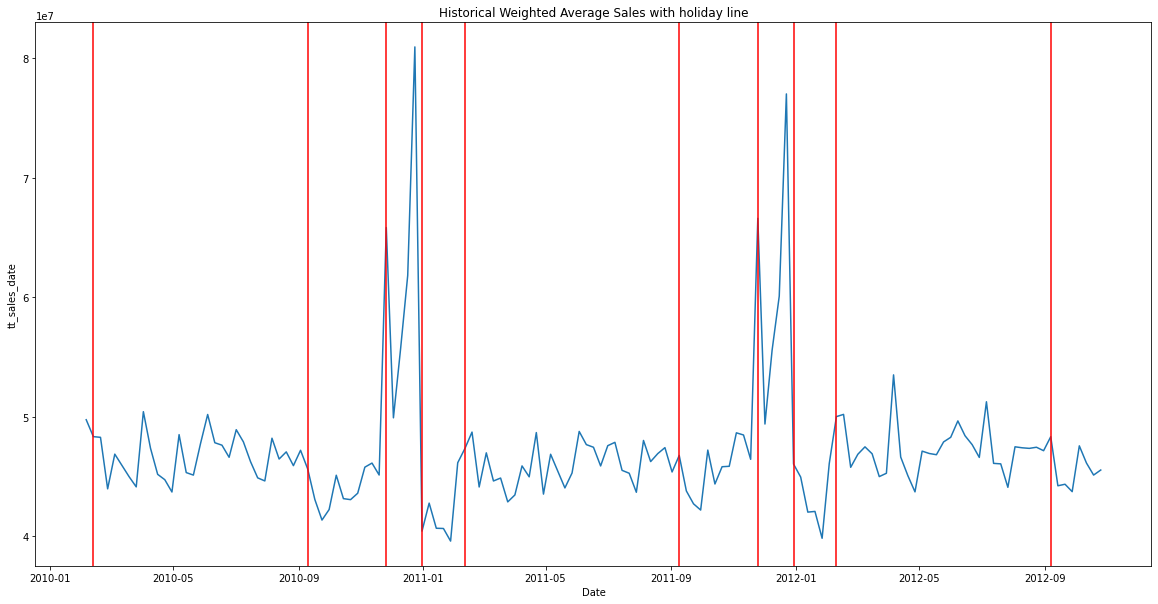

In [18]:
ls_holiday = list(features_train_wavg_df[features_train_wavg_df.IsHoliday].Date.values)


plt.figure(figsize=(20, 10))
g1 = sns.lineplot(data=features_train_wavg_df, x="Date", y="tt_sales_date")

for date in ls_holiday:
    plt.axvline(x=date, color="r", label="axvline - full height")

plt.title("Historical Weighted Average Sales with holiday line")
plt.show()

Text(0.5, 1.0, 'week sales with holiday line')

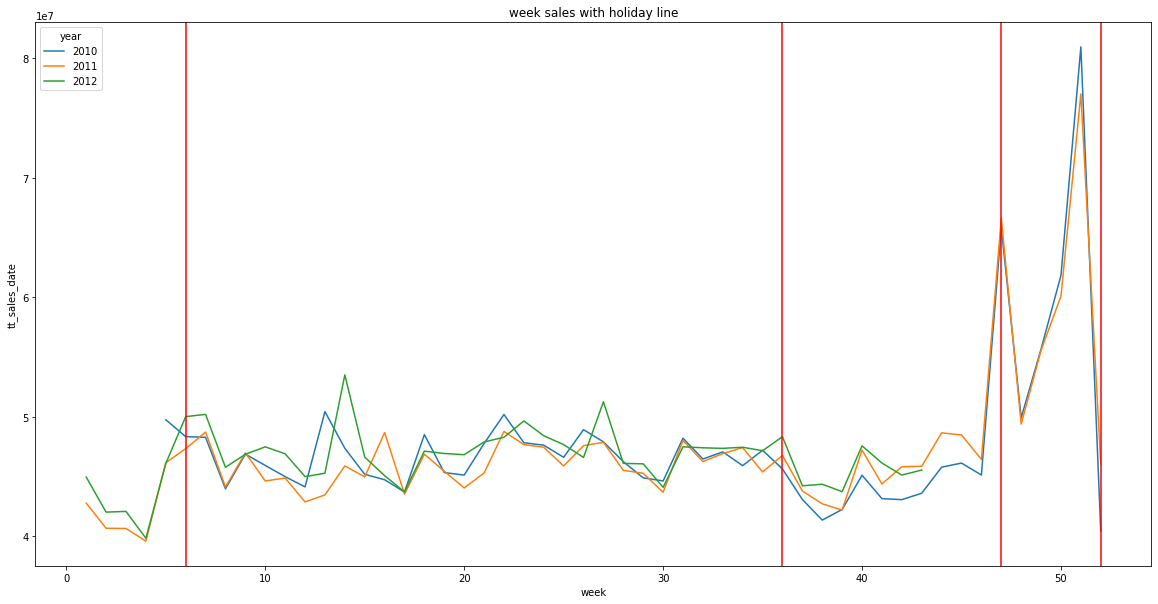

In [19]:
features_train_wavg_df["year"] = features_train_wavg_df.Date.dt.isocalendar().year
features_train_wavg_df["week"] = features_train_wavg_df.Date.dt.isocalendar().week
features_train_wavg_df["month"] = features_train_wavg_df.Date.dt.month
features_train_wavg_df = features_train_wavg_df.astype({"year": str})

ls_week_holiday = set(
    features_train_wavg_df[features_train_wavg_df.IsHoliday].week.values
)

plt.figure(figsize=(20, 10))
g1 = sns.lineplot(data=features_train_wavg_df, x="week", y="tt_sales_date", hue="year")

for date in ls_week_holiday:
    plt.axvline(x=date, color="r", label="axvline - full height")

plt.title("week sales with holiday line")

Text(0.5, 1.0, 'sales with wavg_unemploy  ')

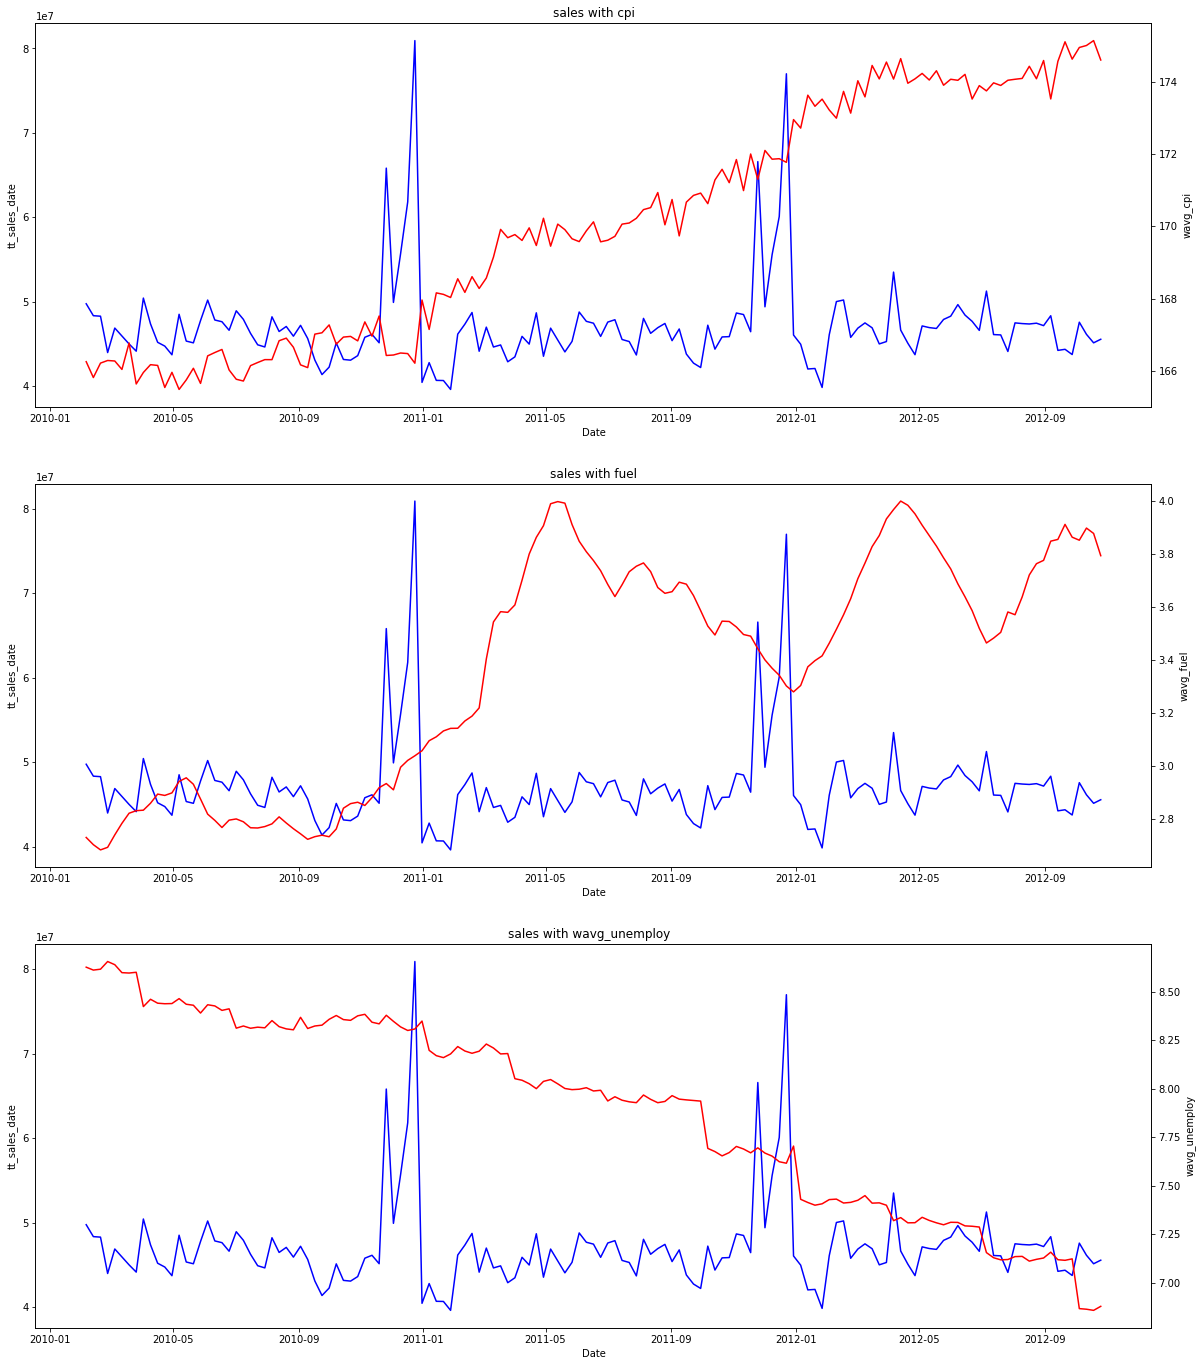

In [20]:
plt.subplots(2, 1, figsize=(20, 8 * 3))

plt.subplot(3, 1, 1)
g1 = sns.lineplot(
    data=features_train_wavg_df, x="Date", y="tt_sales_date", color="blue"
)
g1_ax2 = g1.twinx()
g1_ax2 = sns.lineplot(data=features_train_wavg_df, x="Date", y="wavg_cpi", color="red")
plt.title("sales with cpi")


plt.subplot(3, 1, 2)
g2 = sns.lineplot(
    data=features_train_wavg_df, x="Date", y="tt_sales_date", color="blue"
)
g2_ax2 = g2.twinx()
g2_ax2 = sns.lineplot(data=features_train_wavg_df, x="Date", y="wavg_fuel", color="red")
plt.title("sales with fuel")

plt.subplot(3, 1, 3)
g3 = sns.lineplot(
    data=features_train_wavg_df, x="Date", y="tt_sales_date", color="blue"
)
g3_ax2 = g3.twinx()
g3_ax2 = sns.lineplot(
    data=features_train_wavg_df, x="Date", y="wavg_unemploy", color="red"
)
plt.title("sales with wavg_unemploy  ")

# Analysis Markdown

In [21]:
train_store_features_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6435 entries, 0 to 6434
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          6435 non-null   datetime64[ns]
 1   Store         6435 non-null   int64         
 2   IsHoliday_x   6435 non-null   bool          
 3   Type          6435 non-null   object        
 4   sales         6435 non-null   float64       
 5   Temperature   6435 non-null   float64       
 6   Fuel_Price    6435 non-null   float64       
 7   MarkDown1     2280 non-null   float64       
 8   MarkDown2     1637 non-null   float64       
 9   MarkDown3     2046 non-null   float64       
 10  MarkDown4     1965 non-null   float64       
 11  MarkDown5     2295 non-null   float64       
 12  CPI           6435 non-null   float64       
 13  Unemployment  6435 non-null   float64       
 14  IsHoliday_y   6435 non-null   bool          
dtypes: bool(2), datetime64[ns](1), float64

In [22]:
store_top50 = sales_by_store[sales_by_store.cum_sales_portion <= 0.51].copy()
ls_store_top_50 = list(store_top50.Store)

train_store_features_top50_df = train_store_features_df[train_store_features_df["Store"].isin(ls_store_top_50)].reset_index()

In [23]:
train_store_features_df.describe()

,Store,sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
count,6435.000000,6.435000e+03,6435.000000,6435.000000,2280.000000,1637.000000,2046.000000,1965.000000,2295.000000,6435.000000,6435.000000
mean,23.000000,1.046979e+06,60.663782,3.358607,6855.587430,3218.965504,1349.853021,3303.858142,4435.262240,171.578394,7.999151
std,12.988182,5.643705e+05,18.444933,0.459020,8183.310015,9268.082387,9287.242800,6211.203947,5868.933325,39.356712,1.875885
min,1.000000,2.099862e+05,-2.060000,2.472000,0.270000,-265.760000,-29.100000,0.220000,135.160000,126.064000,3.879000
25%,12.000000,5.533501e+05,47.460000,2.933000,1679.190000,37.200000,4.700000,483.270000,1702.565000,131.735000,6.891000
50%,23.000000,9.607460e+05,62.670000,3.445000,4972.590000,187.040000,22.700000,1419.420000,3186.520000,182.616521,7.874000
75%,34.000000,1.420159e+06,74.940000,3.735000,8873.582500,1785.290000,99.987500,3496.080000,5422.080000,212.743293,8.622000
max,45.000000,3.818686e+06,100.140000,4.468000,88646.760000,104519.540000,141630.610000,67474.850000,108519.280000,227.232807,14.313000


In [24]:
train_store_features_20_df =  train_store_features_df[train_store_features_df.Store == 20]
train_store_features_20_df.describe()

train_store_features_20_df

,Date,Store,IsHoliday_x,Type,sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday_y
19,2010-02-05,20,False,A,2401395.47,25.92,2.784,NaN,NaN,NaN,NaN,NaN,204.247194,8.187,False
64,2010-02-12,20,True,A,2109107.90,22.12,2.773,NaN,NaN,NaN,NaN,NaN,204.385747,8.187,True
109,2010-02-19,20,False,A,2161549.76,25.43,2.745,NaN,NaN,NaN,NaN,NaN,204.432100,8.187,False
154,2010-02-26,20,False,A,1898193.95,32.32,2.754,NaN,NaN,NaN,NaN,NaN,204.463087,8.187,False
199,2010-03-05,20,False,A,2119213.72,31.75,2.777,NaN,NaN,NaN,NaN,NaN,204.494073,8.187,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6229,2012-09-28,20,False,A,2008388.36,58.65,3.997,6245.60,52.64,21.50,3301.81,7195.56,215.736716,7.280,False
6274,2012-10-05,20,False,A,2246411.89,60.77,3.985,5800.66,NaN,33.68,4286.15,3224.25,215.925886,7.293,False
6319,2012-10-12,20,False,A,2162996.18,47.20,4.000,2449.31,NaN,35.08,1019.90,9743.56,216.115057,7.293,False
6364,2012-10-19,20,False,A,1999363.49,56.26,3.969,4174.31,NaN,15.84,838.05,3838.56,216.146470,7.293,False


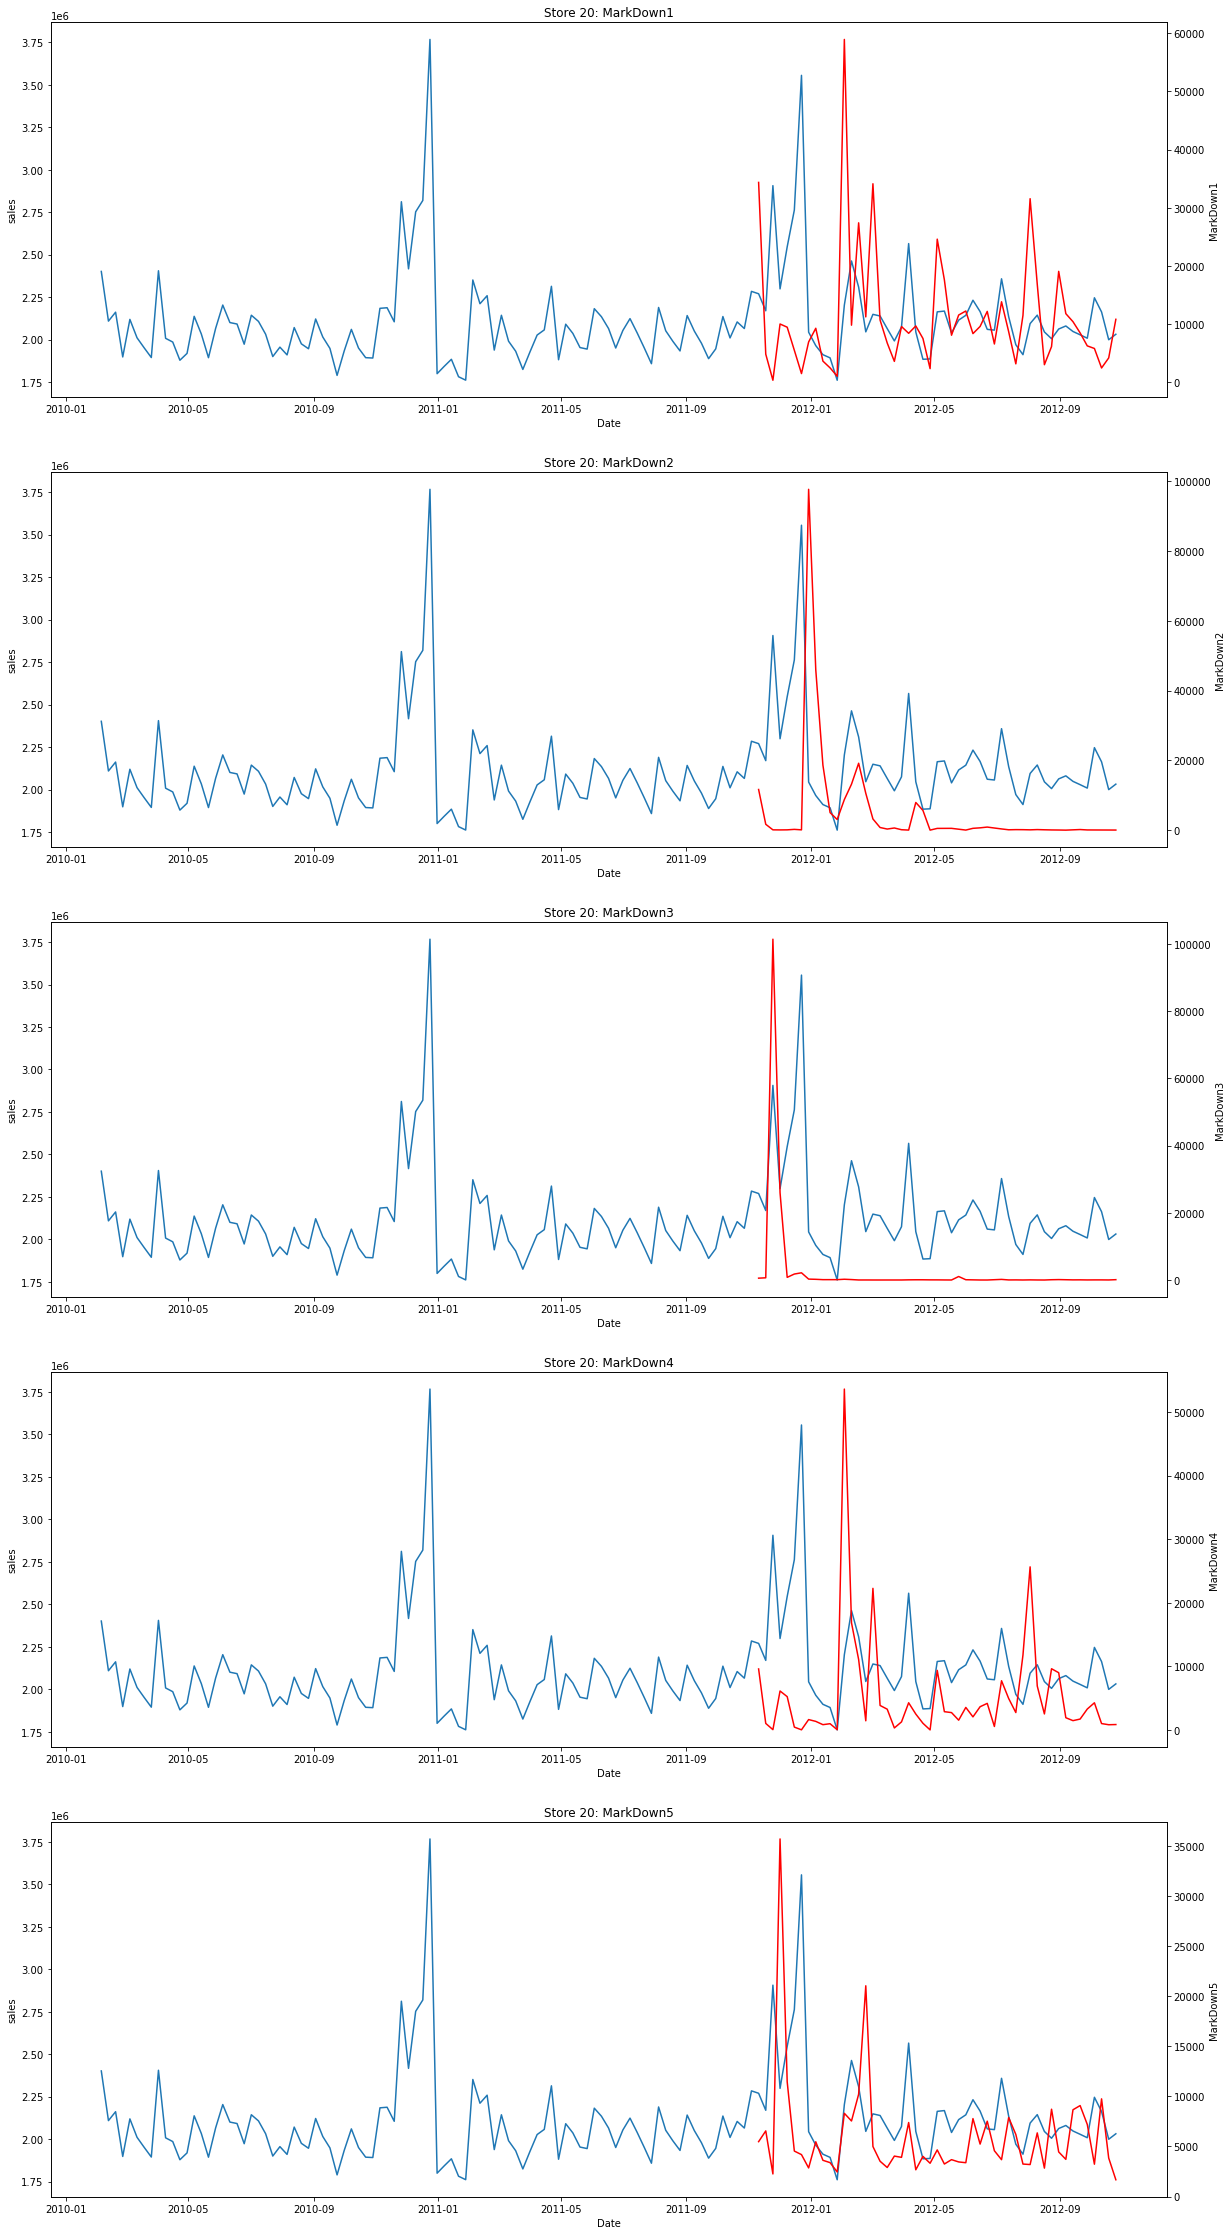

In [25]:
plt.subplots(5, 1, figsize=(20, 8 * 5))

plt.subplot(5, 1, 1)
plt.title("Store 20: MarkDown1")

g1 = sns.lineplot(data=train_store_features_20_df, x=train_store_features_20_df["Date"], y=train_store_features_20_df["sales"])
g1_ax2 = g1.twinx()
g1_ax2 = sns.lineplot(data=train_store_features_20_df, x=train_store_features_20_df["Date"], y=train_store_features_20_df["MarkDown1"], color="r")

plt.subplot(5, 1, 2)
plt.title("Store 20: MarkDown2")

g2 = sns.lineplot(data=train_store_features_20_df, x=train_store_features_20_df["Date"], y=train_store_features_20_df["sales"])
g2_ax2 = g2.twinx()
g2_ax2 = sns.lineplot(data=train_store_features_20_df, x=train_store_features_20_df["Date"], y=train_store_features_20_df["MarkDown2"], color="r")

plt.subplot(5, 1, 3)
plt.title("Store 20: MarkDown3")

g3 = sns.lineplot(data=train_store_features_20_df, x=train_store_features_20_df["Date"], y=train_store_features_20_df["sales"])
g3_ax2 = g3.twinx()
g3_ax2 = sns.lineplot(data=train_store_features_20_df, x=train_store_features_20_df["Date"], y=train_store_features_20_df["MarkDown3"], color="r")

plt.subplot(5, 1, 4)
plt.title("Store 20: MarkDown4")

g4 = sns.lineplot(data=train_store_features_20_df, x=train_store_features_20_df["Date"], y=train_store_features_20_df["sales"])
g4_ax2 = g4.twinx()
g4_ax2 = sns.lineplot(data=train_store_features_20_df, x=train_store_features_20_df["Date"], y=train_store_features_20_df["MarkDown4"], color="r")

plt.subplot(5, 1, 5)
plt.title("Store 20: MarkDown5")

g5 = sns.lineplot(data=train_store_features_20_df, x=train_store_features_20_df["Date"], y=train_store_features_20_df["sales"])
g5_ax2 = g5.twinx()
g5_ax2 = sns.lineplot(data=train_store_features_20_df, x=train_store_features_20_df["Date"], y=train_store_features_20_df["MarkDown5"], color="r")

plt.show()


In [32]:
check_md1 = features_df[features_df.MarkDown1.notnull()]
check_md2 = features_df[features_df.MarkDown2.notnull()]
check_md3 = features_df[features_df.MarkDown3.notnull()]
check_md4 = features_df[features_df.MarkDown4.notnull()]
check_md5 = features_df[features_df.MarkDown5.notnull()]



print(check_md1.Date.min())
print(check_md2.Date.min())
print(check_md3.Date.min())
print(check_md4.Date.min())
print(check_md5.Date.min())

2011-11-11 00:00:00
2011-11-11 00:00:00
2011-11-11 00:00:00
2011-11-11 00:00:00
2011-11-11 00:00:00


<Figure size 1440x720 with 0 Axes>

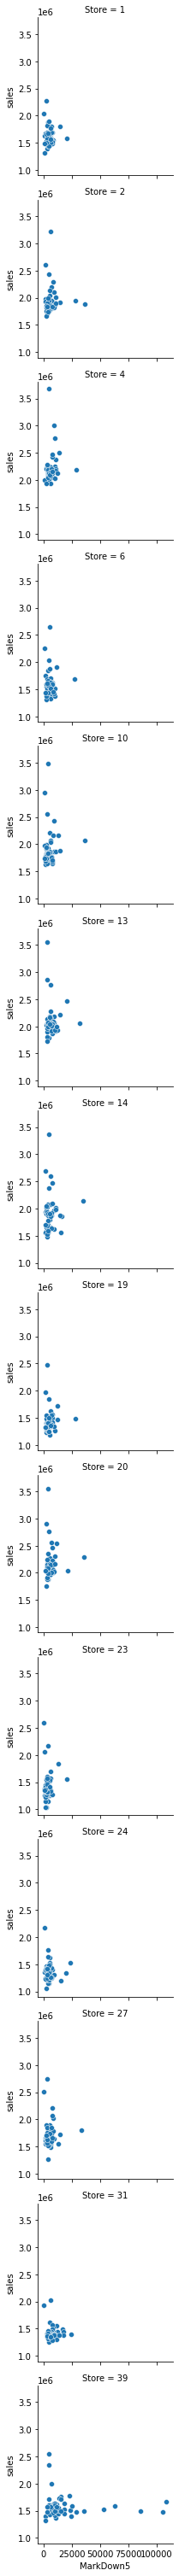

In [26]:
#Markdown 1

plt.figure(figsize=(20, 10))

mark1_plt = sns.FacetGrid(train_store_features_top50_df, row="Store")
mark1_plt.map(sns.scatterplot, "MarkDown5", "sales")


In [27]:
train_store_features_top50_df

,index,Date,Store,IsHoliday_x,Type,sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday_y
0,0,2010-02-05,1,False,A,1643690.90,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-05,2,False,A,2136989.46,40.19,2.572,NaN,NaN,NaN,NaN,NaN,210.752605,8.324,False
2,3,2010-02-05,4,False,A,2135143.87,43.76,2.598,NaN,NaN,NaN,NaN,NaN,126.442065,8.623,False
3,5,2010-02-05,6,False,A,1652694.10,40.43,2.572,NaN,NaN,NaN,NaN,NaN,212.622352,7.259,False
4,9,2010-02-05,10,False,B,2193048.75,54.34,2.962,NaN,NaN,NaN,NaN,NaN,126.442065,9.765,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1997,6412,2012-10-26,23,False,B,1347454.59,50.56,3.917,4782.75,124.72,118.91,1316.96,738.09,138.728161,4.145,False
1998,6413,2012-10-26,24,False,A,1307182.29,55.16,4.071,10844.38,104.16,105.09,1795.68,3059.80,138.728161,8.693,False
1999,6416,2012-10-26,27,False,A,1703047.74,58.99,4.071,7756.75,206.45,100.00,731.23,2174.84,142.762411,8.000,False
2000,6420,2012-10-26,31,False,A,1340232.55,70.50,3.506,10768.84,50.54,104.50,345.37,6629.51,223.078337,6.170,False


In [28]:
ls_store_top_50

[20, 4, 14, 13, 2, 10, 27, 6, 1, 39, 19, 31, 23, 24]